In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Pneumonia.zip -d /content/drive/MyDrive/Pneumonia_data/

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image data generator for augmentation
datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize the pixel values
    rotation_range=15,         # Randomly rotate images by 15 degrees
    width_shift_range=0.1,     # Randomly shift images horizontally (10%)
    height_shift_range=0.1,    # Randomly shift images vertically (10%)
    shear_range=0.2,           # Apply random shear transformations
    zoom_range=0.2,            # Randomly zoom into images
    brightness_range=[0.8, 1.2],  # Adjust brightness
    fill_mode='nearest'        # Fill missing pixels with the nearest pixel
)

# Load data from the directory
train_data = datagen.flow_from_directory(
    '/content/drive/MyDrive/Pneumonia_data/Pneumonia/chest_xray/train',
    target_size=(224, 224),  # Resize to match input size for model
    batch_size=8,            # Small batch size for efficient training
    class_mode='categorical'  # Two classes: 'normal' and 'pneumonia'
)

validation_data = datagen.flow_from_directory(
    '/content/drive/MyDrive/Pneumonia_data/Pneumonia/chest_xray/val',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


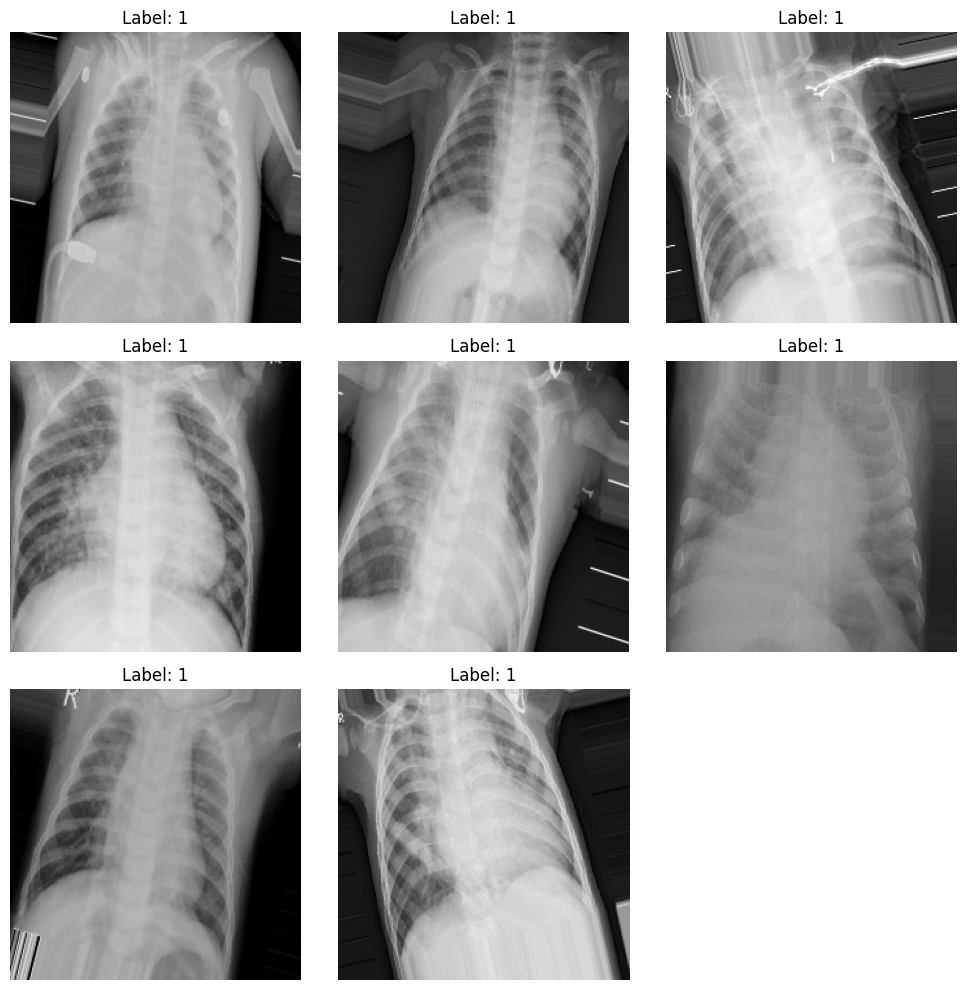

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels
images, labels = next(train_data)  # Fetch a single batch from the training data

# Plot the images
plt.figure(figsize=(10, 10))  # Set the figure size
for i in range(len(images)):
    plt.subplot(3, 3, i + 1)  # Create a subplot for each image
    plt.imshow(images[i])  # Display the image
    plt.title(f"Label: {np.argmax(labels[i])}")  # Show the label
    plt.axis('off')  # Turn off the axis for clarity
plt.tight_layout()
plt.show()


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Concatenate, Reshape, MultiHeadAttention, LayerNormalization

# Input layer
input_shape = (224, 224, 3)
inputs = tf.keras.Input(shape=input_shape)

# EfficientNetB0 feature extraction
efficient_net = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)
efficient_net_output = GlobalAveragePooling2D()(efficient_net.output)

# DenseNet121 feature extraction
dense_net = DenseNet121(include_top=False, weights='imagenet', input_tensor=inputs)
dense_net_output = GlobalAveragePooling2D()(dense_net.output)

# Concatenate features from both networks
concatenated_features = Concatenate()([efficient_net_output, dense_net_output])

# Add Dropout for regularization
concatenated_features = Dropout(0.3)(concatenated_features)

# Reshape concatenated_features for MultiHeadAttention
# MultiHeadAttention expects input shape (batch_size, seq_len, feature_dim)
# Add a new dimension for seq_len (e.g., 1)
reshaped_features = Reshape((1, -1))(concatenated_features)

# Multi-head attention layer
attention_output = MultiHeadAttention(num_heads=4, key_dim=128)(reshaped_features, reshaped_features)
attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

# Flatten the attention output
flattened_output = tf.keras.layers.Flatten()(attention_output)

# Add a fully connected layer
x = Dense(512, activation='relu')(flattened_output)

# Final classification layer
outputs = Dense(2, activation='softmax')(x)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Example usage of model.fit
# model.fit(train_data, epochs=10, validation_data=val_data)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
# Train the model
history = model.fit(train_data, validation_data=validation_data, epochs=5)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


652/652 ━━━━━━━━━━━━━━━━━━━━ 522s 318ms/step - accuracy: 0.7984 - loss: 0.7109 - val_accuracy: 0.5000 - val_loss: 1.1219
Epoch 2/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 172s 262ms/step - accuracy: 0.9160 - loss: 0.2210 - val_accuracy: 0.7500 - val_loss: 0.4784
Epoch 3/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 177s 269ms/step - accuracy: 0.9484 - loss: 0.1405 - val_accuracy: 0.8750 - val_loss: 0.2613
Epoch 4/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 180s 274ms/step - accuracy: 0.9617 - loss: 0.1278 - val_accuracy: 0.7500 - val_loss: 0.4797
Epoch 5/5
652/652 ━━━━━━━━━━━━━━━━━━━━ 196s 263ms/step - accuracy: 0.9515 - loss: 0.1375 - val_accuracy: 0.7500 - val_loss: 0.6008


In [7]:
model.save("with_attention.h5")

In [8]:
# Image data generator for the test set (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test data
test_data = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Pneumonia_data/Pneumonia/chest_xray/test',  # Path to the test dataset
    target_size=(224, 224),  # Resize to match input size for model
    batch_size=8,            # Batch size can be the same as training
    class_mode='categorical',  # Two classes: 'normal' and 'pneumonia'
    shuffle=False            # Important: don't shuffle for evaluation
)


# Evaluate the model
test_loss, test_acc = model.evaluate(test_data)
print(f'Test accuracy: {test_acc}')


Found 624 images belonging to 2 classes.
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.9159 - loss: 0.2750
Test accuracy: 0.9358974099159241


In [9]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Evaluate on the test data
test_loss, test_acc = model.evaluate(test_data)

# Predict on test data to get confusion matrix, precision, recall, etc.
y_true = test_data.classes
y_pred_probs = model.predict(test_data)
y_pred = y_pred_probs.argmax(axis=1)

# Confusion Matrix
print(confusion_matrix(y_true, y_pred))

# Classification Report (precision, recall, f1-score)
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

# AUC score
auc = roc_auc_score(y_true, y_pred_probs[:, 1])
print(f"AUC: {auc}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.9159 - loss: 0.2750


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (8, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


78/78 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step
[[204  30]
 [ 10 380]]
              precision    recall  f1-score   support

      Normal       0.95      0.87      0.91       234
   Pneumonia       0.93      0.97      0.95       390

    accuracy                           0.94       624
   macro avg       0.94      0.92      0.93       624
weighted avg       0.94      0.94      0.94       624

AUC: 0.9809445540214771
